## Read time series data and split

In [1]:
import pandas as pd
import numpy as np
import jax

# Disable JIT compilation
#jax.config.update("jax_disable_jit", True)
#jax.config.update("jax_log_compiles", True)

import jax.numpy as jnp
import discretize_func as discretize
import tokenizer_func as tokenizer
import inference_func as inference
import tokenizer_lib as tl
import pickle
import matplotlib.pyplot as plt

tl.status()

jax 0.8.2 jaxlib 0.8.2
cpu
[CpuDevice(id=0)]


## Pre-processing

* Normalize
* Delta tokens by derivation
* Global discretization

Current setup:
* delta tokens
* n_bins = 1024
* fixed size bins

Future:
* discretize each column individually
* quantile-based bins (centered at 0)

## Tokenize
* Tokenize each row: Channel+Value (on change), special time step token: 0

Token layout

* 0	BOS (beginning of sequence / row)
* CH_0 … CH_6  →  IDs 2 … 8 (channel tokens)
* DATA ≥ DATA_OFFSET = 2 + N_CHANNELS = 9 (data tokens)
* 1	EOS (end of row)

Example:

```python
[BOS,
 CH_0, DATA(x0),
 CH_1, DATA(x1),
 ...
 CH_6, DATA(x6),
 EOS]
```

# Read model

In [2]:
# Load model
#file_name = "token_model_20251222_140751.pkl"
#file_name = "token_model_20251223_140535.pkl"
file_name = "token_model_20251224_070018.pkl"
with open(f"../models/{file_name}", 'rb') as f:
    model_file = pickle.load(f)

globals().update(model_file)
#zero_bin = int(np.argmin(np.abs(mids))) (now part of saved model)

X, Y = tl.get_split_data(path="../data", resample_interval=resample_interval)

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(losses)
plt.title('Loss')
plt.show()

In [5]:
# Cross-entropy ~3.5 corresponds to perplexity exp(3.5) ≈ 33. That can be “fine” or “terrible” depending on:
#	•	how many tokens are actually plausible at each step (if only ~tens are plausible, 33 is not crazy),
print(losses[-1], np.exp(losses[-1]))

1.3510056 3.8613064


## Autoregressive rollout
* Feed in test_tokens context window (same context +1 out)
* Generate one new token, add to context, adhere to grammar
* When a new full sparse frame is complete, [BOS, CH+DATA.., EOS], we make a new row
* Stop when we have stepped block_size (context window size)
* We should now have a dataframe of new deltas

TODO A later test would be to make new test_tokens with minimal columns and see if the model propose covariates.

In [6]:
rng_key = jax.random.PRNGKey(128)

In [16]:
rng_key, subkey = jax.random.split(rng_key)
max_new_tokens = 480  # number of tokens to predict
t = int(jax.random.randint(rng_key, shape=(), minval=0, maxval=len(X)-(3*max_new_tokens)))

# Select a random batch (t)
X_test = X.iloc[t:t+max_new_tokens] 
Y_test = X.iloc[t+max_new_tokens:t+max_new_tokens+max_new_tokens]

# Pre-process it
X_test_normalized = (X_test-mu)/sigma
X_test_normalized = X_test_normalized.diff().dropna()
X_test_nv = X_test_normalized.values.astype(np.float32)   # (N, D)

# Discretize
X_test_tok = discretize.encode_equal_width_global(jnp.asarray(X_test_nv), edges)
test_tokens = tokenizer.encode_with_channels_sparse(X_test_tok, n_channels, zero_bin)
token_stream = test_tokens[-block_size:] # B, T

# Inspect first few tokens
print("Number of tokens:", len(test_tokens))
print("Number of tokens in stream:", len(token_stream))
print("Context window:", block_size)
print("Last context tokens:", token_stream)

Number of tokens: 6558
Number of tokens in stream: 480
Context window: 480
Last context tokens: [1940    8 2121    1    0    2 2052    3 2204    4 2164    5 2016    6
 2500    7 2272    8 2085    1    0    3 2245    4 2093    5 1923    6
 2575    7 2272    8 2097    1    0    2 2079    3 2184    4 1941    5
 1871    6 2161    7 2151    8 2079    1    0    2 2064    3 2184    4
 2084    5 1999    6 2161    7 2219    8 2007    1    0    2 2070    3
 2118    4 2041    5 2025    6 2048    7 2204    8 2037    1    0    2
 2055    3 2077    4 1970    5 2008    6 1954    7 2204    8 2037    1
    0    2 2078    3 2133    4 2144    5 2076    6 2105    7 2272    8
 1989    1    0    2 2083    4 2013    5 2042    6 2086    7 2204    8
 2007    1    0    3 2052    4 1881    5 1991    8 2055    1    0    2
 2079    3 2082    4 2184    5 2118    6 2105    7 2136    8 2010    1
    0    2 2078    3 2016    4 2064    5 2084    6 2048    7 1862    1
    0    2 2121    3 1976    4 1916    5 2033    6 2

In [17]:
rng_key, subkey = jax.random.split(rng_key)
token_stream_padded = inference.pad_tokens(token_stream)

new_tokens = inference.generate_continue(
    variables,
    model.apply,
    token_stream=token_stream,
    rng_key=rng_key,
    vocab_size=vocab_size,
    block_size=block_size,
    max_new_tokens=max_new_tokens,
    n_channels=n_channels,
)

In [18]:
# Convert from stream to channel matrix
tokens_padded = inference.pad_tokens(new_tokens)
rows, n = inference.decode_with_channels_stream(tokens_padded, n_channels)
new_Y_tok = rows[:n]
new_Y_tok

Array([[2139, 1998, 1998,    0, 2660,    0, 2088],
       [   0, 2055, 1998,    0, 2660, 2195, 2088],
       [2111, 2055,    0,    0, 2660,    0, 2088],
       [   0, 2055,    0,    0, 2660, 2195,    0],
       [   0, 2055, 1970,    0, 2660,    0,    0],
       [   0, 2055,    0,    0,    0,    0,    0],
       [   0, 2055, 1970,    0, 2660,    0, 2088],
       [   0, 2055,    0,    0,    0,    0,    0],
       [   0, 2055, 1998,    0, 2660,    0,    0],
       [   0, 2055, 2112,    0, 2660,    0,    0]], dtype=int32)

Delta model, so mu is not added back

$$
\frac{(x_t - \mu) - (x_{t-1} - \mu)}{\sigma}
\quad\equiv\quad
\frac{x_t - x_{t-1}}{\sigma}
$$

In [19]:
# Decode tokens to deltas, cumsum with initial value, and de-normalize
Y_rec = discretize.decode_equal_width_global(new_Y_tok, mids)
Y_rec = pd.DataFrame(Y_rec, columns=X_test_normalized.columns)
Y_rec = Y_rec * sigma # delta model so mu is not added back
init_values = X_test.iloc[-1].values
Y_pred = init_values + jnp.cumsum(Y_rec.values, axis=0)

Y_test = X.iloc[t+max_new_tokens:t+max_new_tokens+len(Y_rec)]
Y_pred = pd.DataFrame(Y_pred, columns=X_test_normalized.columns, index=Y_test.index)
Y_pred

,Power demand,temp,dwpt,rhum,wdir,wspd,pres
datetime,,,,,,,
2021-04-19 16:00:00,4016.064697,36.216969,6.947211,17.5,429.901184,16.600000,1005.899109
2021-04-19 17:00:00,4016.064697,36.155148,5.894422,17.5,589.802368,18.400259,1006.398193
2021-04-19 18:00:00,4174.839844,36.093327,5.894422,17.5,749.703613,18.400259,1006.897278
2021-04-19 19:00:00,4174.839844,36.031506,5.894422,17.5,909.604797,20.200518,1006.897278
2021-04-19 20:00:00,4174.839844,35.969685,4.351498,17.5,1069.505981,20.200518,1006.897278
2021-04-19 21:00:00,4174.839844,35.907864,4.351498,17.5,1069.505981,20.200518,1006.897278
2021-04-19 22:00:00,4174.839844,35.846043,2.808575,17.5,1229.407227,20.200518,1007.396301
2021-04-19 23:00:00,4174.839844,35.784222,2.808575,17.5,1229.407227,20.200518,1007.396301
2021-04-20 00:00:00,4174.839844,35.722401,1.755786,17.5,1389.308350,20.200518,1007.396301


In [20]:
Y_test

,Power demand,temp,dwpt,rhum,wdir,wspd,pres
datetime,,,,,,,
2021-04-19 16:00:00,3739.105000,37.0,2.30,11.5,290.0,18.4,1005.0
2021-04-19 17:00:00,3643.325000,36.8,5.85,15.5,300.0,18.4,1004.5
2021-04-19 18:00:00,3505.280833,35.8,7.25,17.5,295.0,15.7,1005.0
2021-04-19 19:00:00,3521.033333,34.0,4.60,16.0,290.0,11.2,1006.0
2021-04-19 20:00:00,3409.353333,32.3,5.30,18.5,300.0,7.4,1005.5
2021-04-19 21:00:00,3348.980000,31.8,6.40,20.5,325.0,5.4,1006.0
2021-04-19 22:00:00,3487.565833,31.0,7.35,23.0,165.0,2.7,1007.0
2021-04-19 23:00:00,3533.321667,28.6,10.85,34.5,0.0,0.0,1006.5
2021-04-20 00:00:00,3374.436667,27.1,11.40,38.0,15.0,2.7,1006.0


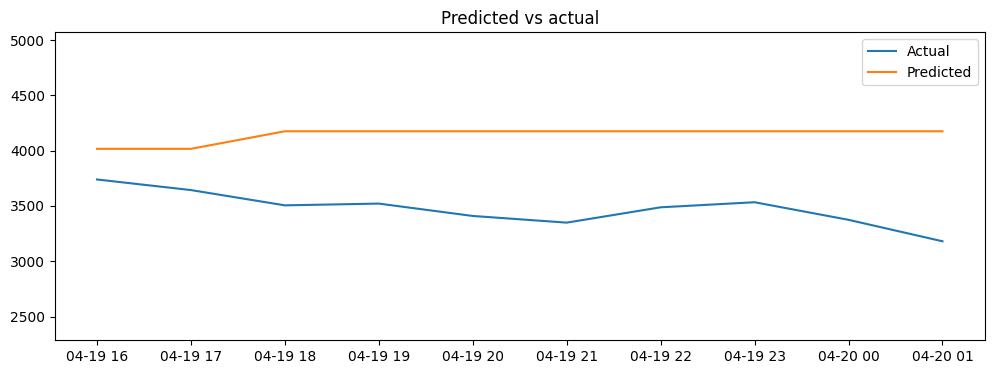

In [23]:
col = 'Power demand'
#col = "rhum"
#col = "temp"

plt.figure(figsize=(12, 4))
plt.plot(Y_test.index, Y_test[col], label="Actual")
plt.plot(Y_pred.index, Y_pred[col], label="Predicted")
plt.margins(y=0.9)
plt.title('Predicted vs actual')
plt.legend()
plt.show()

## Autoregressive rollout with covariates

* Specify covariates values

In [ ]:
# TODO!

## Autoregressive channel hinter

Lets mask away some channels and see if the model hints about the missing channels.

In [ ]:
rng_key, subkey = jax.random.split(rng_key)
max_new_tokens = 480
t = int(jax.random.randint(rng_key, shape=(), minval=0, maxval=len(X)-(3*max_new_tokens)))

# Select a random batch (t)
X_test = X.iloc[t:t+max_new_tokens]
Y_test = X.iloc[t+max_new_tokens:t+max_new_tokens+max_new_tokens].reset_index(drop=True)

# Pre-process it
X_test_normalized = (X_test-mu)/sigma
X_test_normalized = X_test_normalized.diff().dropna()

# Mask out channel 1, 4->
n_cols = X_test_normalized.shape[1]
mask = np.ones(n_cols, dtype=bool)
mask[[1]] = False
mask[2:] = False

X_masked = X_test_normalized.copy()
X_masked.loc[:, ~mask] = 0

X_masked_nv = X_masked.values.astype(np.float32)   # (N, D)

# Discretize
X_masked_tok = discretize.encode_equal_width_global(jnp.asarray(X_masked_nv), edges)
masked_tokens = tokenizer.encode_with_channels_sparse(X_masked_tok, n_channels, zero_bin)
masked_stream = masked_tokens[-block_size:] # B, T

# Inspect first few tokens
print("Number of tokens:", len(masked_tokens))
print("Number of tokens in stream:", len(masked_stream))
print("Context window:", block_size)
print("Last context tokens:", masked_stream)

In [ ]:
X_masked

In [ ]:
masked_stream_padded = inference.pad_tokens(masked_stream)
new_masked_tokens = inference.generate_continue(
    variables,
    model.apply,
    token_stream=masked_stream_padded,
    rng_key=rng_key,
    vocab_size=vocab_size,
    block_size=block_size,
    max_new_tokens=max_new_tokens,
    n_channels=n_channels,
)

In [ ]:
# Convert from sparse stream to all channel matrix
new_masked_tokens_padded = inference.pad_tokens(new_masked_tokens)
rows, n = inference.decode_with_channels_stream(new_masked_tokens_padded, n_channels)
new_masked_tok = rows[:n]
new_masked_tok

In [ ]:
# Decode tokens to deltas, cumsum with initial value, and de-normalize
Y_masked_rec = discretize.decode_equal_width_global(new_masked_tok, mids)
Y_masked_rec = pd.DataFrame(Y_masked_rec, columns=X.columns)
Y_masked_rec = Y_masked_rec * sigma # delta model so mu is not added back

pd.DataFrame(Y_masked_rec)

In [ ]:
# Cumsum
init_values = X_test.iloc[-1].values
Y_masked_pred = init_values + jnp.cumsum(Y_masked_rec.values, axis=0)

Y_test = X.iloc[t+max_new_tokens:t+max_new_tokens+len(Y_masked_pred)]
Y_masked_pred = pd.DataFrame(Y_masked_pred, columns=X.columns, index=Y_test.index)

Y_masked_pred

In [ ]:
col = 'Power demand'
#col = 'temp'
plt.figure(figsize=(12, 4))
plt.plot(Y_test.index, Y_test[col], label="Actual")
plt.plot(Y_masked_pred.index, Y_masked_pred[col], label="Predicted")
plt.title('Predicted vs actual')
plt.legend()
plt.show()